# Elastic workflow

This is a elastic workflow that is based on a stress-strain approach.

If you want to read more about this approach, please check out [https://docs.materialsproject.org/methodology/materials-methodology/elasticity](https://docs.materialsproject.org/methodology/materials-methodology/elasticity) and the following publication [https://www.nature.com/articles/sdata20159](https://www.nature.com/articles/sdata20159).


## Let's start with the workflow

We now simply load the force field elastic workflow. We change from the default universal ML potential to M3GNet. For CHGNet, an updated version of the ML potential needs to be used: [https://github.com/CederGroupHub/chgnet/issues/79](https://github.com/CederGroupHub/chgnet/issues/79)



In [ ]:
from pymatgen.core import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

structure = Structure(
    lattice=[[0, 2.73, 2.73], [2.73, 0, 2.73], [2.73, 2.73, 0]],
    species=["Si", "Si"],
    coords=[[0, 0, 0], [0.25, 0.25, 0.25]],
)

structure = SpacegroupAnalyzer(structure).get_primitive_standard_structure()

In [2]:
from atomate2.forcefields.utils import MLFF
from atomate2.forcefields.jobs import ForceFieldRelaxMaker
from atomate2.forcefields.flows.elastic import ElasticMaker


ff = MLFF.CHGNet

bulk_relax_maker = ForceFieldRelaxMaker(
    force_field_name=ff,
    relax_cell=False,
    relax_kwargs={"fmax": 1e-5},
)

elastic_relax_maker = ForceFieldRelaxMaker(
    force_field_name=ff,
    relax_cell=False,
    relax_kwargs={"fmax": 1e-5},
)

elastic_flow = ElasticMaker(
    bulk_relax_maker=bulk_relax_maker,
    elastic_relax_maker=elastic_relax_maker,
).make(structure)

/home/phy_cmp/python_projects/CHGnet/chgnet-venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch
from pathlib import Path
from typing import Any
from dataclasses import dataclass, field
from chgnet.model.model import CHGNet
from chgnet.model.dynamics import CHGNetCalculator
from atomate2.forcefields.jobs import ForceFieldRelaxMaker

@dataclass
class FineTunedCHGNetRelaxMaker(ForceFieldRelaxMaker):
    ckpt_path: str | Path = field(
        default="/home/phy_cmp/python_projects/CHGnet/12-01-2025/bestE_epoch49_e140_f26_s290_mNA.pth.tar"
    )
    device: str = "cpu"

    @property
    def calculator(self) -> Any:
        checkpoint = torch.load(self.ckpt_path, map_location=self.device)
        state_dict = checkpoint["model"]["state_dict"]

        chgnet = CHGNet.load(model_name="r2scan")
        chgnet.load_state_dict(state_dict)

        calc = CHGNetCalculator(model=chgnet, use_device=self.device)
        return calc

In [ ]:
from atomate2.forcefields.flows.elastic import ElasticMaker

bulk_relax_maker = FineTunedCHGNetRelaxMaker(
    name="CHGNet bulk relax (fine-tuned)",
    relax_cell=True,
    relax_kwargs={"fmax": 1e-5},
)

elastic_relax_maker = FineTunedCHGNetRelaxMaker(
    name="CHGNet elastic relax (fine-tuned)",
    relax_cell=False,
    relax_kwargs={"fmax": 1e-5},
)

elastic_flow = ElasticMaker(
    bulk_relax_maker=bulk_relax_maker,
    elastic_relax_maker=elastic_relax_maker,
).make(structure)

## Let's have a look at the computing jobs
The phonon run will first perform a bulk relaxation, then the displacements are generated and run.
As we currently don't have a way to compute BORN charges with such potentials, a non-analytical term correction is not performed here.


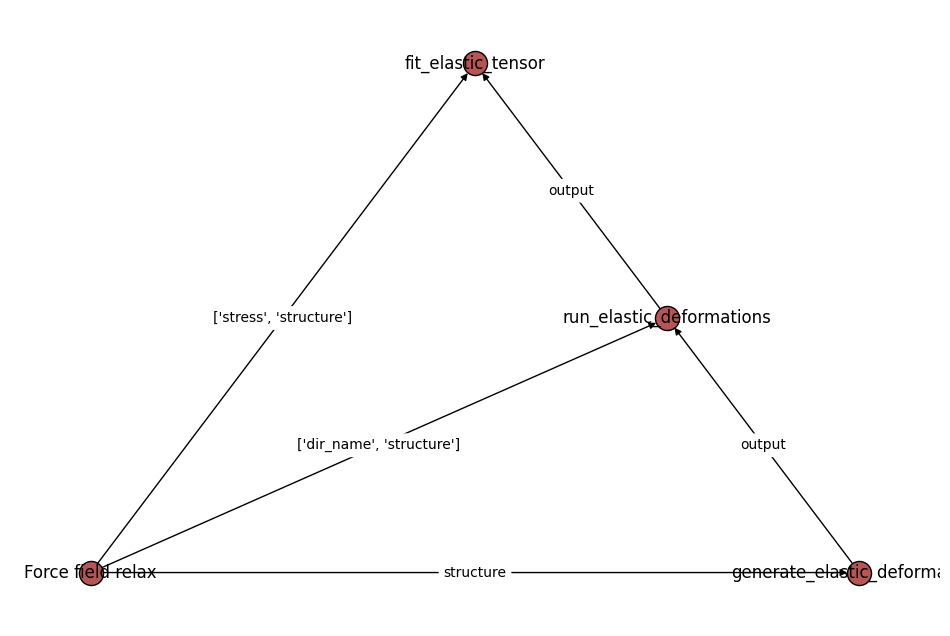

In [3]:
elastic_flow.draw_graph().show()

## Let's execute the workflow

In [4]:
%%capture
from jobflow import run_locally

responses = run_locally(elastic_flow,  create_folders=True)

## Let's have a look at the outputs

We query our database for the relevant outputs (here results from the elastic document)


In [5]:
from jobflow import SETTINGS

store = SETTINGS.JOB_STORE
store.connect()

result = store.query_one(
    {"name": "fit_elastic_tensor"},
    properties=[
        "output.elastic_tensor",
        "output.derived_properties",
    ],
    load=True,
    sort={"completed_at": -1}
)

You can then access the elastic tensor in different output formats:

In [12]:
from pymatgen.analysis.elasticity.elastic import ElasticTensor

C_voigt = result["output"]["elastic_tensor"]["ieee_format"]
C = ElasticTensor.from_voigt(C_voigt)
print(C.voigt)


[[1.35961502e+02 4.47804959e+01 4.47804959e+01 2.74104379e-16
  8.91320102e-15 2.54519442e-14]
 [4.47804959e+01 1.35961502e+02 4.47804959e+01 5.78157392e-16
  3.03564863e-15 2.65197433e-14]
 [4.47804959e+01 4.47804959e+01 1.35961502e+02 1.04033058e-15
  9.00890935e-15 8.80307112e-15]
 [2.74104379e-16 5.78157392e-16 1.04033058e-15 4.18167771e+01
  8.22046937e-15 2.83477968e-15]
 [8.91320102e-15 3.03564863e-15 9.00890935e-15 8.22046937e-15
  4.18167771e+01 2.55993685e-16]
 [2.54519442e-14 2.65197433e-14 8.80307112e-15 2.83477968e-15
  2.55993685e-16 4.18167771e+01]]


And, derived properties such as bulk moduli can be accessed:

In [ ]:
print(print(result["output"])

In [13]:
print(result["output"]["derived_properties"])

{'k_voigt': 75.17416464533325, 'k_reuss': 75.17416464533324, 'k_vrh': 75.17416464533324, 'g_voigt': 43.32626752923942, 'g_reuss': 43.24873206291268, 'g_vrh': 43.28749979607605, 'universal_anisotropy': 0.008963900515506218, 'homogeneous_poisson': 0.2584492719462232, 'y_mod': 108950245205.48837, 'trans_v': 4345.749630200318, 'long_v': 7614.3171024049125, 'snyder_ac': 102.2972494567895, 'snyder_opt': 0.2511232271221628, 'snyder_total': 102.54837268391167, 'clark_thermalcond': None, 'cahill_thermalcond': 1.2179611655004874, 'debye_temperature': 526.672413604312}


In [ ]:
from pymatgen.core import Structure

def kappa_slack_from_derived(
    derived_props: dict,
    structure: Structure,
    gamma: float,
    T: float = 300.0,
    n_atoms_primitive: int | None = None,
    A: float = 3.1e-6,
) -> float:

    theta_D = derived_props["debye_temperature"] 

    comp = structure.composition
    M_av_g_per_mol = comp.weight / len(structure) 
    M_av_amu = M_av_g_per_mol

    V = structure.volume * 1e-30
    n_atoms_conv = len(structure)
    V_atom = V / n_atoms_conv
    delta = V_atom ** (1.0 / 3.0)

    n = n_atoms_conv if n_atoms_primitive is None else n_atoms_primitive

    kappa = A * M_av_amu * theta_D**3 * delta / (gamma**2 * n**(2.0 / 3.0) * T)

    return kappa

In [ ]:
gamma_guess = 1.8  # твоя оценка для DHH
k_slack = kappa_slack_from_derived(
    derived_props=derived,
    structure=structure,
    gamma=gamma_guess,
    T=300.0,
    n_atoms_primitive=None,  # или явно число атомов в примитивной ячейке
)

print("Debye T from derived_properties:", derived["debye_temperature"])
print(f"κ_L (Slack, γ={gamma_guess}) ≈ {k_slack:.2f} W/mK")